# Test for denoise- and smoothing filters for the EIS toolkit
The toolkit contains focal and denoising filters.
NoData input will result in NoData output.

**Focal filter**:
- Focal mean
- Focal median
- Gaussian
- Mexican Hat (Ricker wavelet)

**Denoise filter**
- Lee additive noise
- Lee multiplicative noise
- Lee additive and multiplicative noise
- Gamma
- Frost
- Kuan

## Imports and needed files

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import sys
sys.path.append('..')

from eis_toolkit.raster_processing.filters import focal, speckle, kernels
from eis_toolkit.raster_processing.filters import utilities as utils

np.set_printoptions(suppress=True)

# Path to data
file_paths = ['../tests/data/remote/small_raster.tif']

# Select data
file_path = file_paths[0]

raster = rasterio.open(file_path)


c:\Users\steffen\.conda\envs\eis_toolkit\lib\site-packages\beartype\_util\hint\pep\utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Sequence[str] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


## Helper

### Show kernels

In [2]:
def show_kernel_multi(kernels, params, cmap='inferno'):
  # Create a figure with subplots for each kernel
  ncols = 5
  nimages = len(params)
  nrows = np.ceil(nimages / ncols).astype(int)
    
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5))

  for i, param in enumerate(params):   
      # Plot the filter on its corresponding subplot
      row = i // ncols
      col = i % ncols
      image = axs[row, col].imshow(kernels[i], cmap=cmap)
      axs[row, col].set_title(f'Parameter = {param}')
      axs[row, col].axis('off')
      
      # Add colorbar and specify number of ticks
      cbar = plt.colorbar(image, ax=axs[row, col])
      cbar.ax.yaxis.set_major_locator(MaxNLocator(4))
      
  plt.tight_layout()
  plt.show();

### Show results

In [3]:
def show_results(input, result):
  # Create a figure with two subplots side by side
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

  colormap = 'viridis'
  # Plot the first array on the first subplot
  input_image = ax1.imshow(input, cmap=colormap)
  ax1.set_title('Input')
  ax1.axis('off')
  fig.colorbar(input_image, ax=ax1, orientation='vertical')

  # Plot the second array on the second subplot
  result_image = ax2.imshow(result, cmap=colormap)
  ax2.set_title('Result')
  ax2.axis('off')
  fig.colorbar(result_image, ax=ax2, orientation='vertical')
  
  plt.show();


### Create data

In [4]:
np.random.seed(42)

example_1 = np.random.rand(20, 20)

## Focal filter

### Mean and Median
For **squared shaped** filters, the kernel consists only of **ones**.

#### Kernels

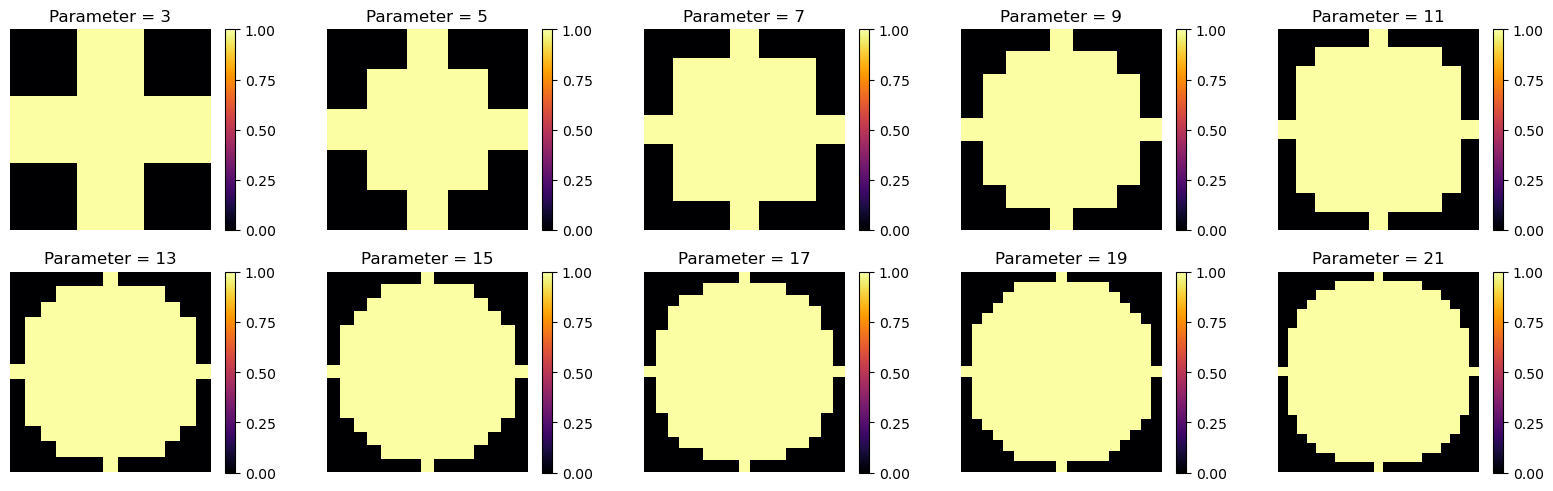

In [5]:
sizes = list(np.arange(3, 23, 2))
kernels_list = []

for i, size in enumerate(sizes):
  filter = kernels.basic_kernel(int(size), shape='circle')
  kernels_list.append(filter)
  
show_kernel_multi(kernels_list, sizes)

#### Filter

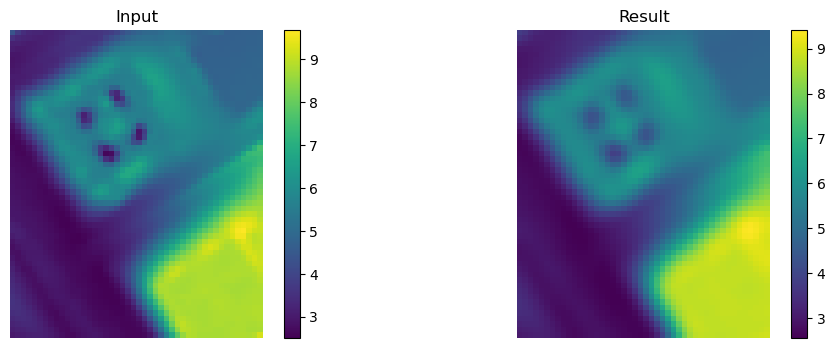

In [6]:
# Mean
filter, _ = focal.focal_filter(raster, size=5, method="mean", shape="circle")
show_results(raster.read(1), filter)

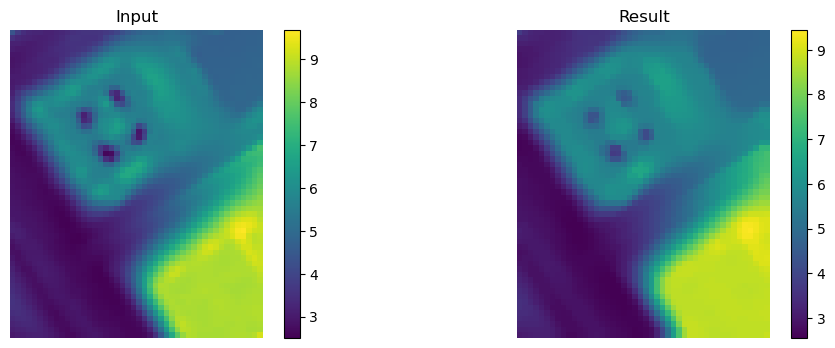

In [7]:
# Median
filter, _ = focal.focal_filter(raster, size=5, method="median", shape="circle")
show_results(raster.read(1), filter)

### Gaussian

#### Kernels

##### Dynamic size

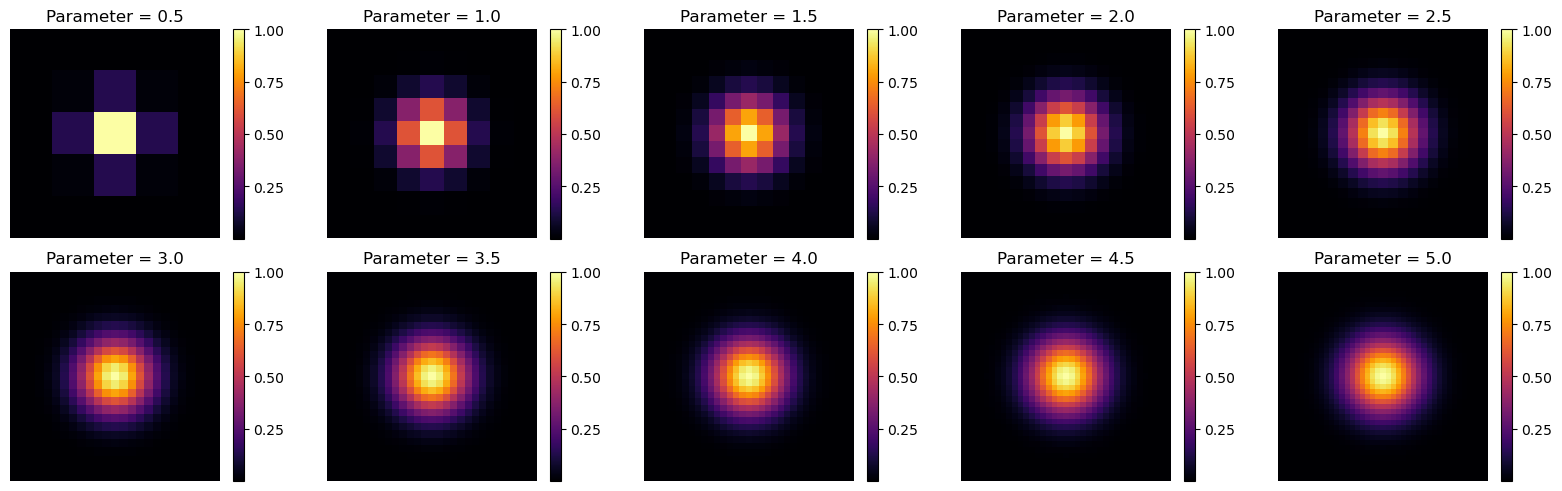

In [8]:
sigmas = list(np.linspace(0.5, 5, 10))
kernels_list = []

for i, sigma in enumerate(sigmas):
  filter = kernels.gaussian_kernel(sigma=sigma, truncate=4, size=None)
  kernels_list.append(filter)
  
show_kernel_multi(kernels_list, sigmas)

##### Fixed size

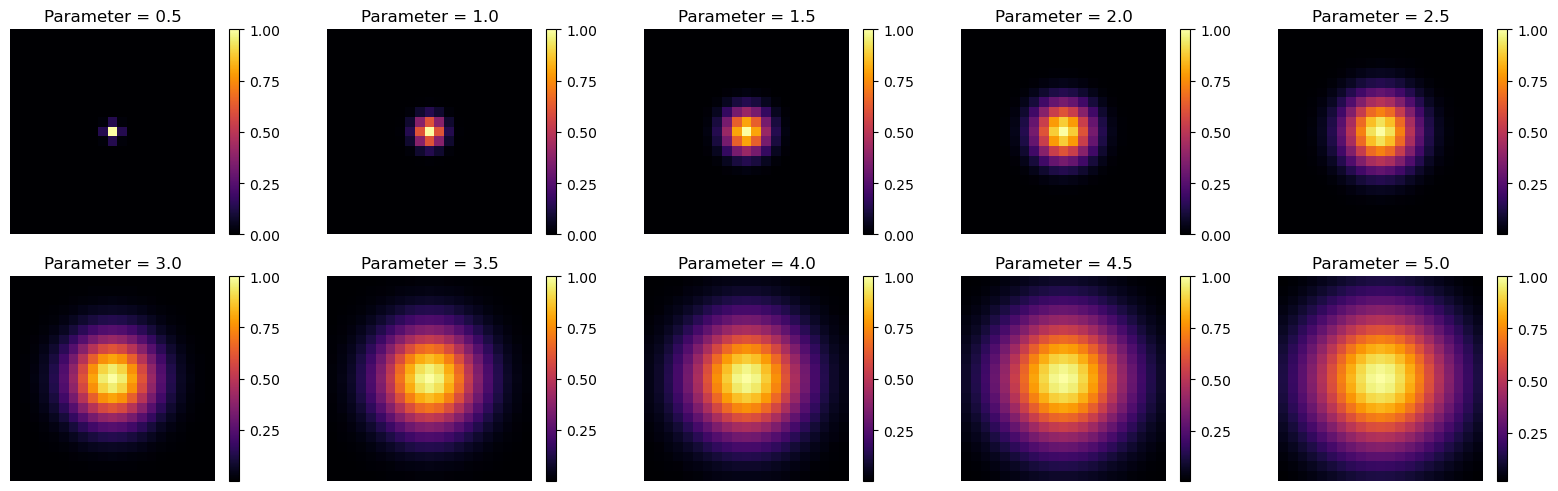

In [9]:
sigmas = list(np.linspace(0.5, 5, 10))
kernels_list = []

for i, sigma in enumerate(sigmas):
  filter = kernels.gaussian_kernel(sigma=sigma, truncate=4, size=21)
  kernels_list.append(filter)
  
show_kernel_multi(kernels_list, sigmas)

#### Filter

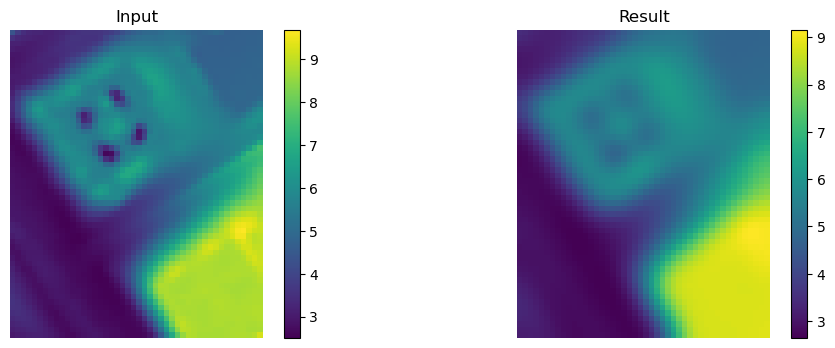

In [10]:
# Gaussian
filter, _ = focal.gaussian_filter(raster, sigma=2, truncate=4)
show_results(raster.read(1), filter)

### Mexican Hat

#### Kernels

##### Circular value distribution

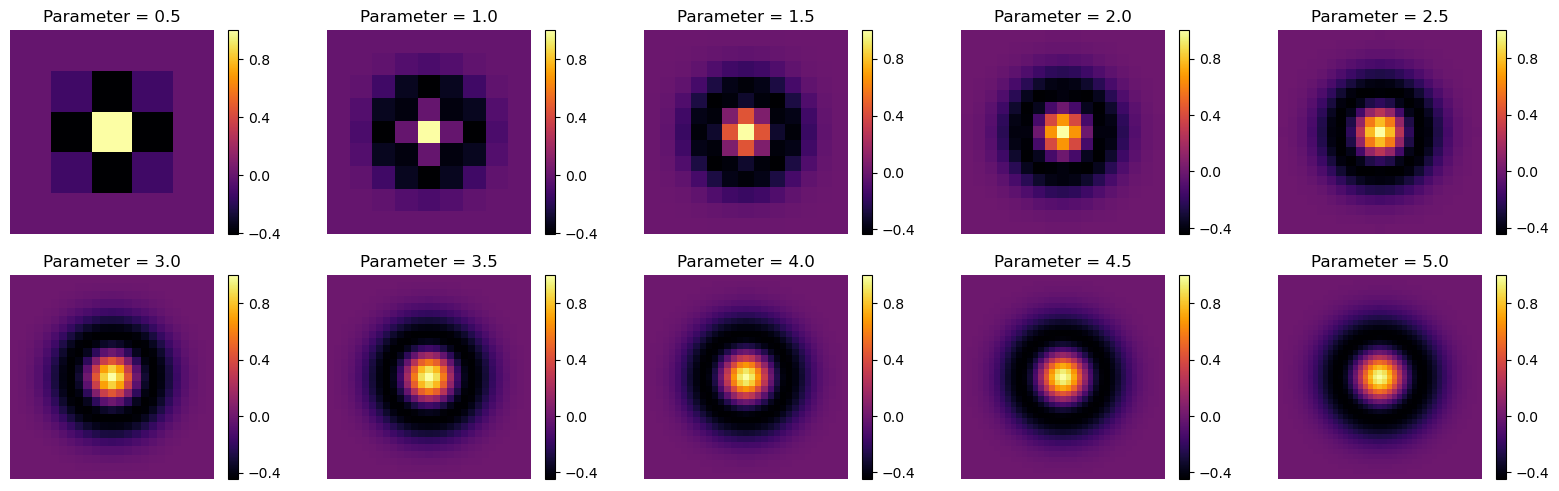

In [11]:
sigmas = list(np.linspace(0.5, 5, 10))
kernels_list = []

for i, sigma in enumerate(sigmas):
  filter = kernels.mexican_hat_kernel(sigma=sigma, truncate=4, size=None, direction="circular")
  kernels_list.append(filter)
  
show_kernel_multi(kernels_list, sigmas)

##### Rectangular value distribution

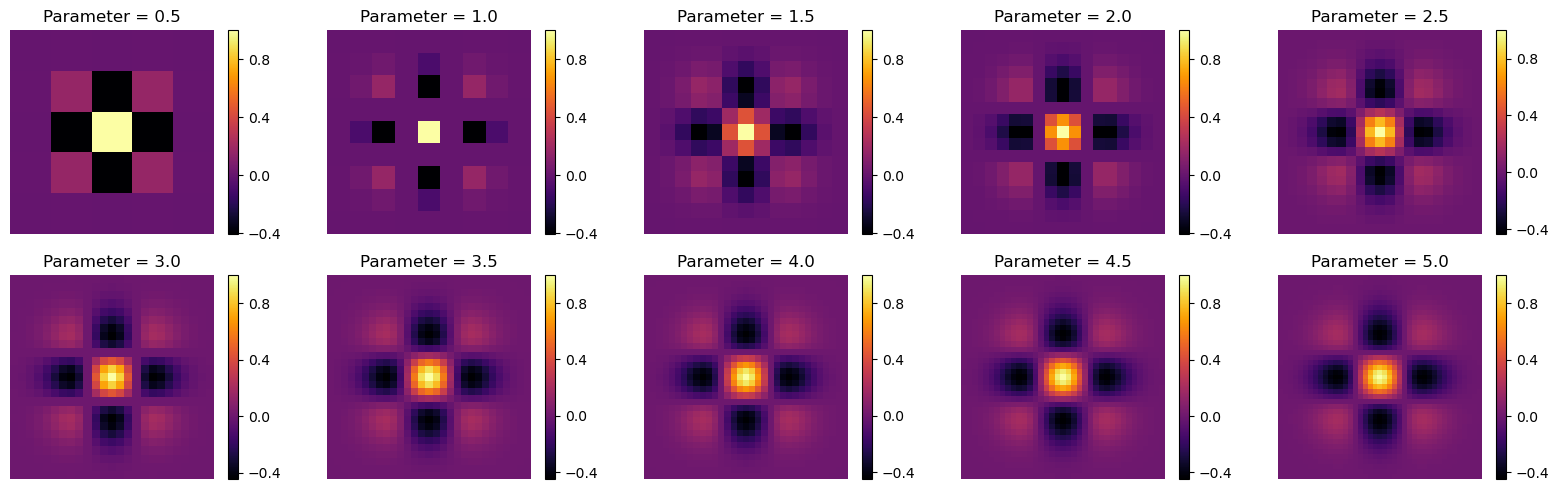

In [12]:
sigmas = list(np.linspace(0.5, 5, 10))
kernels_list = []

for i, sigma in enumerate(sigmas):
  filter = kernels.mexican_hat_kernel(sigma=sigma, truncate=4, size=None, direction="rectangular")
  kernels_list.append(filter)
  
show_kernel_multi(kernels_list, sigmas)

#### Filter

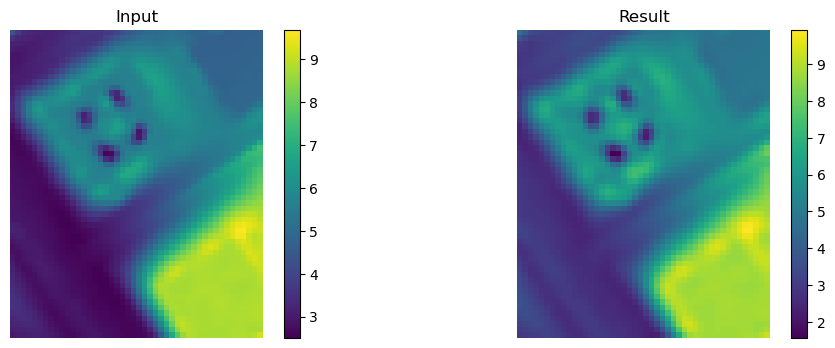

In [13]:
# Circular for smoothing
filter, _ = focal.mexican_hat_filter(raster, sigma=2, size=5, direction="circular")
show_results(raster.read(1), filter)

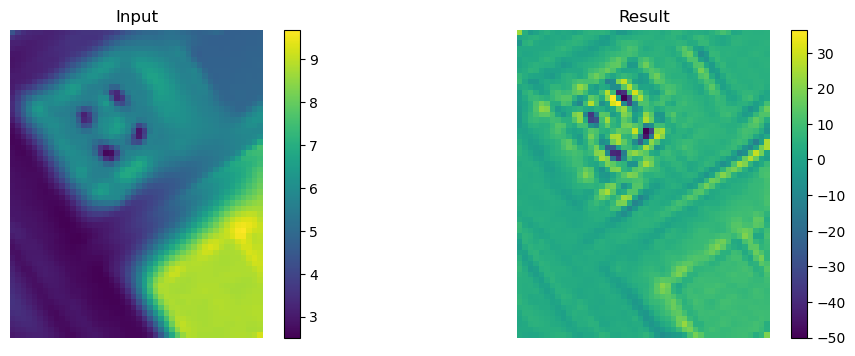

In [14]:
# Rectangular for edge detection
filter, _ = focal.mexican_hat_filter(raster, sigma=1, truncate=4, size=5, direction="rectangular")
show_results(raster.read(1), filter)

## Speckle filter
Since the kernels consits of **ones only** for the specific size choosen, we skip the visualization for those.

### Lee additive noise

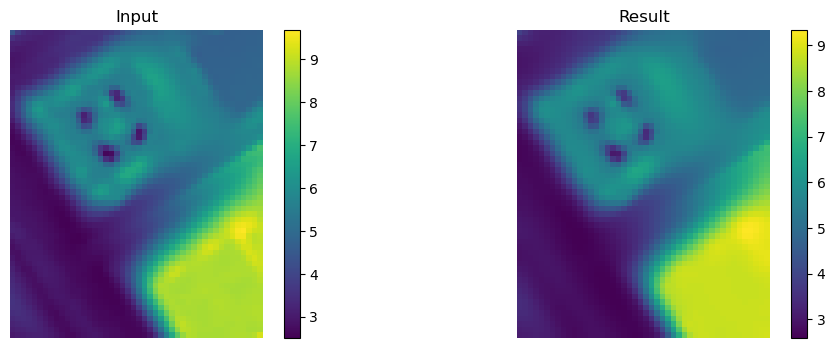

In [15]:
filter, _ = speckle.lee_additive_noise_filter(raster, size=5, add_noise_var=0.25)
show_results(raster.read(1), filter)

### Lee multiplicative noise

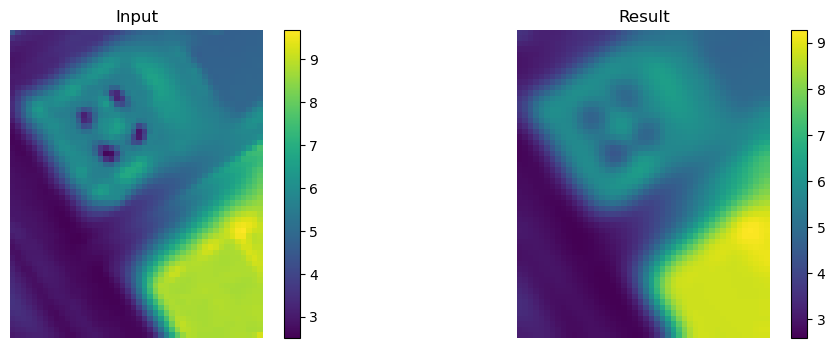

In [16]:
filter, _ = speckle.lee_multiplicative_noise_filter(raster, size=5, mult_noise_mean=1, n_looks=1)
show_results(raster.read(1), filter)

### Lee additive and multiplicative noise

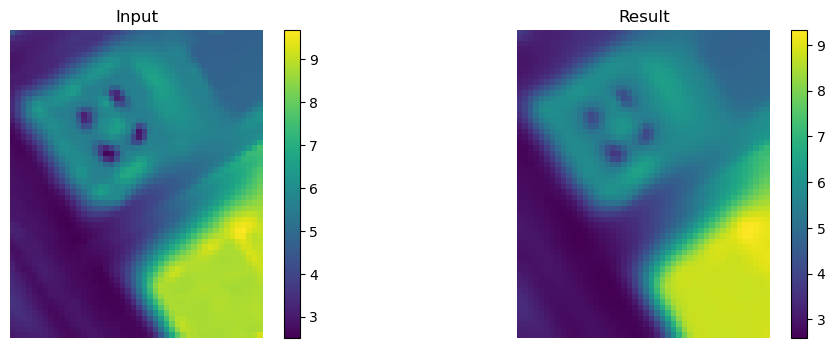

In [17]:
filter, _ = speckle.lee_additive_multiplicative_noise_filter(raster, size=5, add_noise_var=0.25, add_noise_mean=0, mult_noise_mean=1)
show_results(raster.read(1), filter)

### Lee enhanced
For a low **number of looks**, this filter can result in a rectangular shaped **mean** filter.

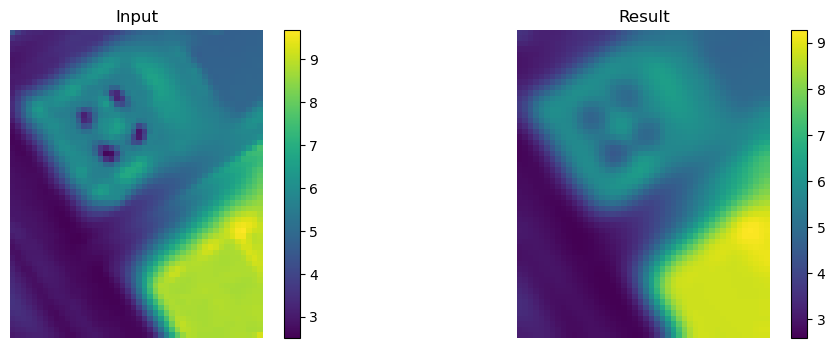

In [18]:
filter, _ = speckle.lee_enhanced_filter(raster, size=5, n_looks=1, damping_factor=1)
show_results(raster.read(1), filter)

### Gamma
For a low **number of looks**, this filter can result in a rectangular shaped **mean** filter.<br>
Higher **number of looks** also results in better edge preservation.

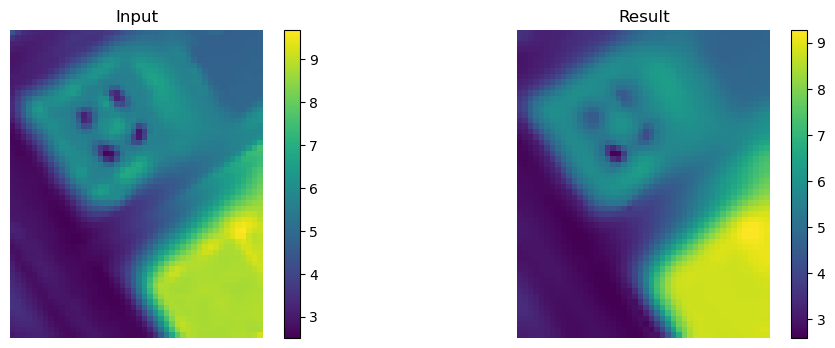

In [19]:
filter, _ = speckle.gamma_filter(raster, size=5, n_looks=50)
show_results(raster.read(1), filter)

### Frost
Higher **damping factor** also results in better edge preservation.

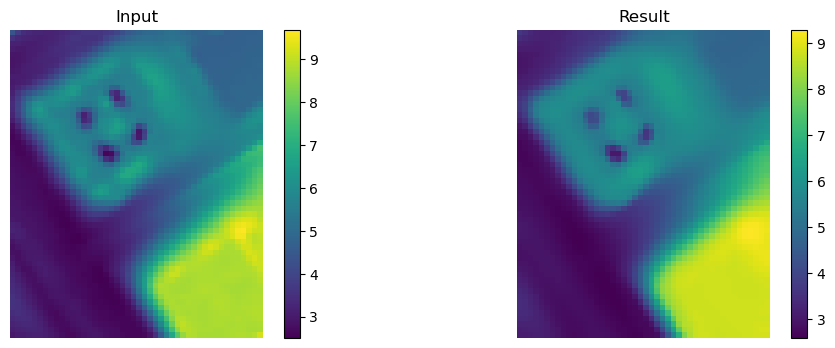

In [20]:
filter, _ = speckle.frost_filter(raster, size=5, damping_factor=50)
show_results(raster.read(1), filter)

### Kuan
For a low **number of looks**, this filter can result in a rectangular shaped **mean** filter.<br>
Higher **number of looks** also results in better edge preservation.

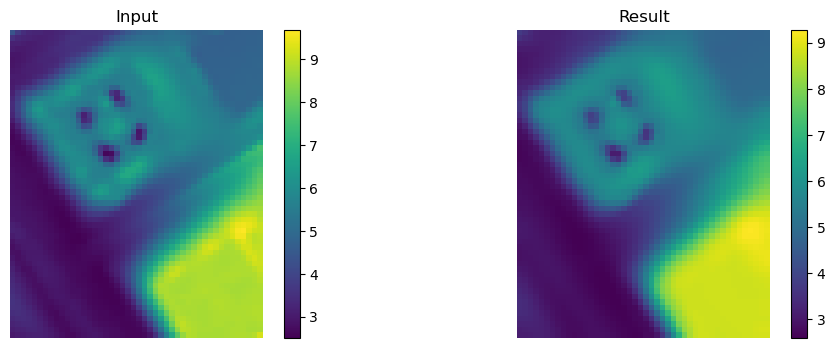

In [21]:
filter, _ = speckle.kuan_filter(raster, size=5, n_looks=100)
show_results(raster.read(1), filter)